<div>
    <div><img src="images/drivendata-logo.svg" alt="drawing" width="100"/></div>
    <br>
    <div><img src="images/nepal-quake-bm-2.jfif" alt="drawing" width="400"/></div>
</div>

## Richter's Predictor: Modeling Earthquake Damage
##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### Modélisation en considérant les 3 niveaux géographiques comme des données numériques


##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Chargement du fichier et agrégation aux niveaux 1 et 2 et sur la cible (target)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_train_values='data/train_values.csv'
file_train_labels='data/train_labels.csv'

df_val = pd.read_csv(file_train_values,sep=",",header=0)
df_label = pd.read_csv(file_train_labels,sep=",",header=0)
print('Shape du fichier des valeurs d\'entraînement : {}'.format(df_val.shape))
print('Shape du fichier des cibles d\'entraînement : {}'.format(df_label.shape))
print('\nValeurs')
display(df_val.head())
print('\nCibles')
display(df_label.head())

Shape du fichier des valeurs d'entraînement : (260601, 39)
Shape du fichier des cibles d'entraînement : (260601, 2)

Valeurs


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0



Cibles


,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


### Fonctions de préparation des données

##### Catégorisation des colonnes : fonction categorized

In [2]:
# Catégorisation des colonnes : fonction categorized
def categorized(data, columns_bool, columns_category):    
    data[data_columns_bool]=data[columns_bool].astype(bool)
    data[data_columns_category]=data[columns_category].astype('category')
    return data

#### Pour mise en place d'un polynôme degré 2, 3 et 1/2 1/3 et 1x2, 1x2x3 sur geo_level : fonction polynôme

In [3]:
# Pour mise en place d'un polynôme degré 2 et 1/2 sur geo_level : fonction polynôme
import math

def polynome(data):
    data['geo_level_1_id2']=data['geo_level_1_id']**2
    data['geo_level_2_id2']=data['geo_level_2_id']**2
    data['geo_level_3_id2']=data['geo_level_3_id']**2

    data['geo_level_1_id05']=data['geo_level_1_id']**0.5
    data['geo_level_2_id05']=data['geo_level_2_id']**0.5
    data['geo_level_3_id05']=data['geo_level_3_id']**0.5
    
    data['geo_level_1_id3']=data['geo_level_1_id']**3
    data['geo_level_2_id3']=data['geo_level_2_id']**3
    data['geo_level_3_id3']=data['geo_level_3_id']**3
    
    data['geo_level_1_id03']=data['geo_level_1_id']**0.333
    data['geo_level_2_id03']=data['geo_level_2_id']**0.333
    data['geo_level_3_id03']=data['geo_level_3_id']**0.333
    
    data['geo_level_12_id']=data['geo_level_1_id']*data['geo_level_2_id']
    data['geo_level_123_id']=data['geo_level_1_id']*data['geo_level_2_id']*data['geo_level_3_id']
    
    #data['geo_level_sin12_id']=math.pi*data['geo_level_12_id']/data['geo_level_12_id'].max()
    #data['geo_level_sin123_id']=math.pi*data['geo_level_123_id']/data['geo_level_123_id'].max()
    
    return data

#### Application d'un MinMaxScaler : fonction scalered

In [4]:
# Application d'un MinMaxScaler : fonction scalered
from sklearn.preprocessing import MinMaxScaler

def scalered(data, columns):
    scaler = MinMaxScaler()
    data_scaler=scaler.fit_transform(data[columns])
    data_scaled=data
    data_scaled[columns]=data_scaler
    return data_scaled

##### Application d'un Get_dummies sur les colonnes catégorisées : fonction dummy

In [5]:
# Application d'un Get_dummies sur les colonnes catégorisées : fonction dummy
def dummy(data):
    return pd.get_dummies(data)

### Préparation effective des données

In [6]:
data_columns_bool=['has_superstructure_adobe_mud','has_superstructure_mud_mortar_stone','has_superstructure_stone_flag',\
        'has_superstructure_cement_mortar_stone','has_superstructure_mud_mortar_brick',\
        'has_superstructure_timber','has_superstructure_bamboo',\
        'has_superstructure_cement_mortar_brick','has_superstructure_rc_non_engineered','has_superstructure_rc_engineered',\
        'has_superstructure_other','has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel',\
        'has_secondary_use_rental','has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry',\
        'has_secondary_use_health_post','has_secondary_use_gov_office','has_secondary_use_use_police','has_secondary_use_other']

data_columns_category=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type',\
                       'position', 'plan_configuration', 'legal_ownership_status']

data_columns_integer=['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',\
                      'geo_level_12_id', 'geo_level_123_id',\
                      #'geo_level_sin12_id', 'geo_level_sin123_id',\
                      'geo_level_1_id2', 'geo_level_2_id2', 'geo_level_3_id2',\
                      'geo_level_1_id05', 'geo_level_2_id05', 'geo_level_3_id05',\
                      'geo_level_1_id3', 'geo_level_2_id3', 'geo_level_3_id3',\
                      'geo_level_1_id03', 'geo_level_2_id03', 'geo_level_3_id03',\
                      'count_floors_pre_eq','age','area_percentage','height_percentage', 'count_families']

In [7]:
data=categorized(df_val,data_columns_bool, data_columns_category)
data=polynome(data)
data_scaled=scalered(data, data_columns_integer)
display(data_scaled[data_columns_integer].head(10))
#data_scaled.info()
data_scaled_extended = dummy(data_scaled)
print("Shape final : {}\n".format(str(data_scaled_extended.shape)))
data_scaled_extended.info()

# VERSION NON MISE A L'ECHELLE
data_no_scaled_extended = dummy(data)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,geo_level_12_id,geo_level_123_id,geo_level_1_id2,geo_level_2_id2,geo_level_3_id2,geo_level_1_id05,geo_level_2_id05,...,geo_level_2_id3,geo_level_3_id3,geo_level_1_id03,geo_level_2_id03,geo_level_3_id03,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
0,0.200000,0.341275,0.970637,0.070022,0.073391,0.040000,0.116469,0.942137,0.447214,0.584188,...,0.039748,0.914473,0.585117,0.699075,0.990125,0.125,0.030151,0.050505,0.100000,0.111111
1,0.266667,0.630694,0.223761,0.172538,0.041689,0.071111,0.397775,0.050069,0.516398,0.794162,...,0.250874,0.011203,0.643943,0.857708,0.607404,0.125,0.010050,0.070707,0.166667,0.111111
2,0.700000,0.254380,0.714013,0.182674,0.140844,0.490000,0.064709,0.509814,0.836660,0.504361,...,0.016461,0.364014,0.888010,0.633907,0.893890,0.125,0.010050,0.040404,0.100000,0.111111
3,0.733333,0.292922,0.850959,0.220369,0.202494,0.537778,0.085803,0.724131,0.856349,0.541223,...,0.025134,0.616206,0.901873,0.664398,0.947675,0.125,0.010050,0.050505,0.100000,0.111111
4,0.366667,0.091801,0.118405,0.034532,0.004415,0.134444,0.008427,0.014020,0.605530,0.302987,...,0.000774,0.001660,0.715982,0.451469,0.491397,0.250,0.030151,0.070707,0.233333,0.111111
5,0.266667,0.391030,0.484523,0.106973,0.055968,0.071111,0.152905,0.234762,0.516398,0.625324,...,0.059790,0.113748,0.643943,0.731486,0.785615,0.125,0.010050,0.080808,0.100000,0.111111
6,0.300000,0.332866,0.960134,0.102444,0.106212,0.090000,0.110800,0.921857,0.547723,0.576946,...,0.036882,0.885106,0.669702,0.693291,0.986544,0.125,0.025126,0.020202,0.066667,0.111111
7,0.666667,0.226349,0.973661,0.154805,0.162759,0.444444,0.051234,0.948016,0.816497,0.475761,...,0.011597,0.923046,0.873699,0.609735,0.991151,0.125,0.000000,0.070707,0.133333,0.111111
8,0.000000,0.530484,0.574441,0.000000,0.000000,0.000000,0.281413,0.329982,0.000000,0.728343,...,0.149285,0.189555,0.000000,0.809684,0.831436,0.125,0.015075,0.070707,0.133333,0.111111
9,0.866667,0.620883,0.079096,0.552025,0.047148,0.751111,0.385496,0.006256,0.930949,0.787961,...,0.239348,0.000495,0.953465,0.853242,0.429621,0.000,0.000000,0.121212,0.066667,0.111111


Shape final : (260601, 83)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 83 columns):
building_id                               260601 non-null int64
geo_level_1_id                            260601 non-null float64
geo_level_2_id                            260601 non-null float64
geo_level_3_id                            260601 non-null float64
count_floors_pre_eq                       260601 non-null float64
age                                       260601 non-null float64
area_percentage                           260601 non-null float64
height_percentage                         260601 non-null float64
has_superstructure_adobe_mud              260601 non-null bool
has_superstructure_mud_mortar_stone       260601 non-null bool
has_superstructure_stone_flag             260601 non-null bool
has_superstructure_cement_mortar_stone    260601 non-null bool
has_superstructure_mud_mortar_brick       260601 non-null bool
has_superstructure_c

### Fonction de mesure du temps d'exécution LoggerTimer

In [8]:
import time

def time_HMS(s):
    try:
        return time.strftime('%Hh %M\' %S\" ', time.gmtime(s))
    except:
        return ''    
class Timer(object):  
    def __enter__(self):  
        self.start()  
        # __enter__ must return an instance bound with the "as" keyword  
        return self        
    # There are other arguments to __exit__ but we don't care here  
    def __exit__(self, *args, **kwargs):   
        self.stop()        
    def start(self):  
        if hasattr(self, 'interval'):  
            del self.interval  
        self.start_time = time.time()    
    def stop(self):  
        if hasattr(self, 'start_time'):  
            self.interval = time.time() - self.start_time  
            del self.start_time # Force timer reinit  
class LoggerTimer(Timer):  
    @staticmethod  
    def default_logger(msg):  
        print (msg)    
    def __init__(self, prefix='', func=None):  
        # Use func if not None else the default one  
        self.f = func or LoggerTimer.default_logger  
        # Format the prefix if not None or empty, else use empty string  
        self.prefix = ' {0}: '.format(prefix if prefix else '0')  
    def stop(self):  
        # Call the parent method  
        super(LoggerTimer, self).stop()  
        # Call the logging function with the message  
        self.f('{0}{1}'.format(self.prefix, time_HMS(self.interval)))   

### Fonction d'affichage graphique du TOP xx des colonnes utilisées

In [9]:
def top_feature_importance(data, importance_values, nb_top):
    indices = np.argsort(importance_values)[::-1]
    top=np.min([nb_top, data.shape[1]])
    indices=indices[:top]
    plt.figure(1, figsize=(20, 5))
    plt.title("Feature importances : TOP {}".format(top))
    plt.bar(range(top), importance_values[indices], color="r", align="center", alpha=0.5)
    plt.xticks(range(top), data.columns[indices], rotation='90')
    plt.xlim([-1,top])
    plt.show()

## Construction des modèles

#### Constitution bases d'entraînement et base de test  (des colonnes ne sont pas prise en compte, building_id par exemple)

In [10]:
from sklearn.model_selection import train_test_split

cols_a_enlever = ['building_id']
cols_a_conserver=[col for col in data_scaled_extended.columns if col not in cols_a_enlever ]
X_train, X_test, y_train, y_test = train_test_split(data_scaled_extended[cols_a_conserver], df_label['damage_grade']\
                                                    , stratify=df_label['damage_grade'], random_state=94)

# version2 sur les données non mises à l'échelle
X_train2, X_test2, y_train2, y_test2 = train_test_split(data_no_scaled_extended[cols_a_conserver], df_label['damage_grade']\
                                                        , stratify=df_label['damage_grade'], random_state=94)

##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Modèle Bayésien naïf - GaussianNB : clf (très rapide mais piètre résultat)

In [12]:
from sklearn.naive_bayes import GaussianNB

with LoggerTimer("Durée d'exécution "):   
    clf = GaussianNB()
    clf.fit(X_train, y_train) 

print('Bayésien naïf - GaussianNB - Précision sur entraînement : {:.4f}'.format(clf.score(X_train, y_train)))
print('Bayésien naïf - GaussianNB - Précision sur test : {:.4f}'.format(clf.score(X_test, y_test)))

 Durée d'exécution : 00h 00' 01" 
Bayésien naïf - GaussianNB - Précision sur entraînement : 0.4188
Bayésien naïf - GaussianNB - Précision sur test : 0.4216


#### Modèle DecisionTreeClassifier : tree

 Durée d'exécution : 00h 00' 05" 
DecisionTreeClassifier - Précision sur entraînement : 0.9872
DecisionTreeClassifier - Précision sur test : 0.6608


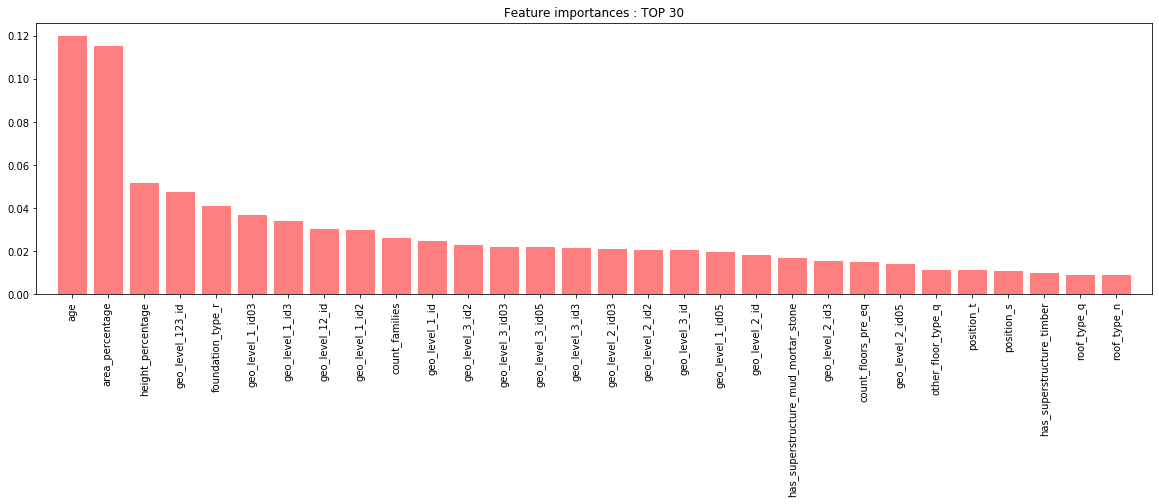

In [13]:
from sklearn.tree import DecisionTreeClassifier

with LoggerTimer("Durée d'exécution "):  
    tree = DecisionTreeClassifier(random_state=94)
    tree.fit(X_train, y_train)
print('DecisionTreeClassifier - Précision sur entraînement : {:.4f}'.format(tree.score(X_train, y_train)))
print('DecisionTreeClassifier - Précision sur test : {:.4f}'.format(tree.score(X_test, y_test)))
importances = tree.feature_importances_
top_feature_importance(X_train, importances, 30)

Démonstration que le recalibrage des données n'influe pas sur l'arbre de décision

In [51]:
with LoggerTimer("Durée d'exécution en secondes"):   
    tree2 = DecisionTreeClassifier(random_state=94)
    tree2.fit(X_train2, y_train2)

print('DecisionTreeClassifier sans mise à l\'échelle - Précision sur entraînement : {:.4f}'\
      .format(tree2.score(X_train2, y_train2)))
print('DecisionTreeClassifier sans mise à l\'échelle - Précision sur test : {:.4f}'\
      .format(tree2.score(X_test2, y_test2)))

 Durée d'exécution en secondes: 00h 00' 04" 
DecisionTreeClassifier sans mise à l'échelle - Précision sur entraînement : 0.9872
DecisionTreeClassifier sans mise à l'échelle - Précision sur test : 0.6608


#### Modèle RandomForestClassifier : forest

#### le résultat s'avère bien meilleur mais le test de soumission s'est avéré au final très mauvais (0.4734) hors polynome

Le passage au degré 2 a permis de passerr de 0.717 à 0.729 puis à 0.733 en ajoutant 0.5 et avec mise à l'échelle ensuite
Passage 0.737 avec ajout degré 3 et 0.333.

L'élimination préalable de building_id réduit ensuite le score

 Durée d'exécution : 00h 00' 49" 
RandomForestClassifier - Précision entraînement 100 Estimateurs : 0.9871
RandomForestClassifier - Précision test Profondeur 100 Estimateurs : 0.7287


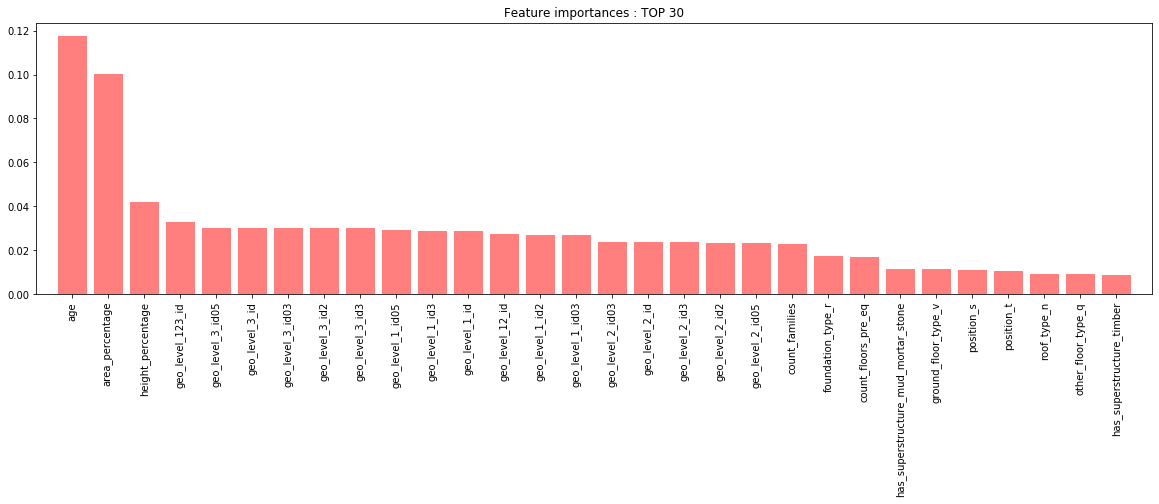

In [20]:
from sklearn.ensemble import RandomForestClassifier

n_estimators=100
with LoggerTimer("Durée d'exécution "):  
    forest = RandomForestClassifier(n_estimators=n_estimators, random_state = 94)
    forest.fit(X_train, y_train)
print("RandomForestClassifier - Précision entraînement {} Estimateurs : {:.4f}"\
      .format(n_estimators, forest.score(X_train, y_train)))
print("RandomForestClassifier - Précision test Profondeur {} Estimateurs : {:.4f}"\
      .format(n_estimators, forest.score(X_test, y_test)))
importances=np.mean([tree.feature_importances_ for tree in forest.estimators_], axis=0)
top_feature_importance(X_train, importances, 30)

#### Modèle RandomForestClassifier : RandomizedSearchCV pour orienter vers les bons paramètres

In [22]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [100, 200, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 60, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [23]:
with LoggerTimer("Durée d'exécution "): 
  
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,\
                                   n_iter = 20, cv = 3, verbose=2, random_state=94, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train)
    print('\nMeilleurs paramètres sur Randomized Search')
    print(rf_random.best_params_)
    print('Précision sur test : {:.4f}'.format(rf_random.score(X_test, y_test)))
    
    

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 20.8min finished



Meilleurs paramètres sur Randomized Search
{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}
Précision sur test : 0.7494
 Durée d'exécution : 00h 23' 04" 


#### Modèle RandomForestClassifier : GridSearchCV pour affiner les paramètres

In [16]:
from sklearn.model_selection import GridSearchCV

with LoggerTimer("Durée d'exécution "): 
    # Create the parameter grid based on the results of random search 
    param_grid = {
        'bootstrap': [True],
        'max_depth': [60, 80],
        'max_features': ['auto', 'log2'],
        'min_samples_leaf': [2, 3],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [300]
    }
    # Create a based model
    rf = RandomForestClassifier(random_state=94)
    # Instantiate the grid search model
    grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose = 2)
    grid.fit(X_train, y_train)
print("RandomForestClassifier - Meilleur score GridSearchCV : {:.4f}".format(grid.best_score_))
print("RandomForestClassifier - Meilleurs parametres GridSearchCV: ", grid.best_params_)
print("RandomForestClassifier - Score du test : {:.4f}".format(grid.score(X_test, y_test)))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=300 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=300, total= 1.4min
[CV] bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=300 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV]  bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=300, total= 1.4min
[CV] bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=300, total= 1.4min
[CV] bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300, total= 1.4min
[CV] bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300, total= 1.4min
[CV] bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth

[CV]  bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total= 1.1min
[CV] bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=300, total= 1.5min
[CV] bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=300, total= 1.5min
[CV] bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=300, total= 1.5min
[CV] bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=80

[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total= 1.0min
[CV] bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total= 1.0min
[CV] bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total= 1.0min


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 89.4min finished


 Durée d'exécution : 01h 31' 31" 
RandomForestClassifier - Meilleur score GridSearchCV : 0.7438
RandomForestClassifier - Meilleurs parametres GridSearchCV:  {'bootstrap': True, 'max_depth': 60, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 300}
RandomForestClassifier - Score du test : 0.7484


param_grid = {
        'bootstrap': [True],
        'max_depth': [60, 80],
        'max_features': ['auto', 'log2'],
        'min_samples_leaf': [2, 3],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [300]
    }
    
Fitting 3 folds for each of 12 candidates, totalling 36 fits

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.

[Parallel(n_jobs=-2)]: Done  36 out of  36 | elapsed: 25.1min finished

 Durée d'exécution : 00h 28' 42" 
 
RandomForestClassifier - Meilleur score GridSearchCV : 0.7442

RandomForestClassifier - Meilleurs parametres GridSearchCV:  {'bootstrap': True, 'max_depth': 60, 'max_features': 'auto', 
'min_samples_leaf': 2, 'min_samples_split': 14, 'n_estimators': 500}

RandomForestClassifier - Score du test : 0.7487

Démonstration que le recalibrage des données n'influe pas sur la forêt aléatoire

In [53]:
n_estimators=100

with LoggerTimer("Durée d'exécution "):  
    forest2 = RandomForestClassifier(n_estimators=n_estimators, random_state = 94)
    forest2.fit(X_train2, y_train2)
print("RandomForestClassifier sans mise à l\'échelle - Précision entraînement {} Estimateurs : {:.4f}"\
      .format(n_estimators, forest2.score(X_train2, y_train2)))
print("RandomForestClassifier sans mise à l\'échelle - Précision test Profondeur {} Estimateurs : {:.4f}"\
      .format(n_estimators, forest2.score(X_test2, y_test2)))

 Durée d'exécution : 00h 00' 49" 
RandomForestClassifier sans mise à l'échelle - Précision entraînement 100 Estimateurs : 0.9871
RandomForestClassifier sans mise à l'échelle - Précision test Profondeur 100 Estimateurs : 0.7287


In [54]:
n_estimators=100
max_features = 16 # racine carrée du nombre de colonnes par défaut donc 8 dans ce cas

with LoggerTimer("Durée d'exécution "):  
    forest3 = RandomForestClassifier(n_estimators=n_estimators, random_state = 94)
    forest3.fit(X_train2, y_train2)
print("RandomForestClassifier max_features = {} - Précision entraînement {} Estimateurs : {:.4f}"\
      .format(max_features, n_estimators, forest3.score(X_train2, y_train2)))
print("RandomForestClassifier max_features = {} - Précision test Profondeur {} Estimateurs : {:.4f}"\
      .format(max_features, n_estimators, forest3.score(X_test2, y_test2)))

 Durée d'exécution : 00h 00' 49" 
RandomForestClassifier max_features = 16 - Précision entraînement 100 Estimateurs : 0.9871
RandomForestClassifier max_features = 16 - Précision test Profondeur 100 Estimateurs : 0.7287


Les variations sur n_estimators et max_features n'influencent pas le score

In [20]:
n_estimators=1000
max_features = 4 # racine carrée du nombre de colonnes par défaut donc 8 dans ce cas

with LoggerTimer("Durée d'exécution "):  
    forest4 = RandomForestClassifier(n_estimators=n_estimators, random_state = 94)
    forest4.fit(X_train2, y_train2)
print("RandomForestClassifier max_features = {} - Précision entraînement {} Estimateurs : {:.4f}"\
      .format(max_features, n_estimators, forest4.score(X_train2, y_train2)))
print("RandomForestClassifier max_features = {} - Précision test Profondeur {} Estimateurs : {:.4f}"\
      .format(max_features, n_estimators, forest4.score(X_test2, y_test2)))

 Durée d'exécution : 00h 08' 36" 
RandomForestClassifier max_features = 4 - Précision entraînement 1000 Estimateurs : 1.0000
RandomForestClassifier max_features = 4 - Précision test Profondeur 1000 Estimateurs : 0.7389


##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### Modèle GradientBoostingClassifier : gbrt_3

In [168]:
from sklearn.ensemble import GradientBoostingClassifier

L'ajout du polynôme ne modifie pas le résultat du gbrt_3

In [169]:
with LoggerTimer("Durée d'exécution "):  
    gbrt_3 = GradientBoostingClassifier(random_state=94)
    gbrt_3.fit(X_train, y_train)
print("GradientBoostingClassifier - Précision entraînement : {:.4f}".format(gbrt_3.score(X_train, y_train)))
print("GradientBoostingClassifier - Précision test : {:.4f}".format(gbrt_3.score(X_test, y_test)))

 Durée d'exécution : 00h 03' 52" 
GradientBoostingClassifier - Précision entraînement : 0.6849
GradientBoostingClassifier - Précision test : 0.6842


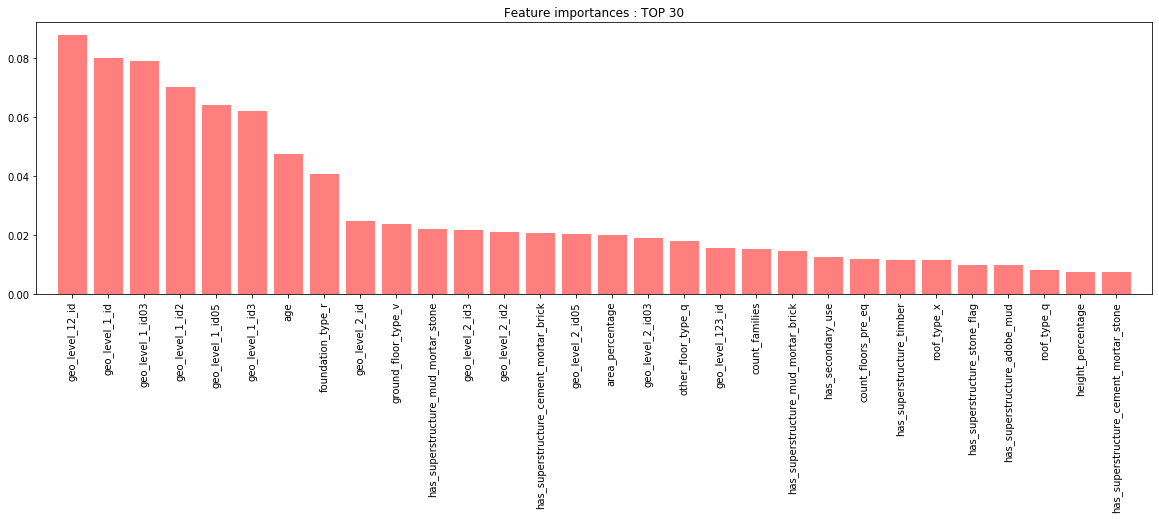

In [173]:
def mean_tree(data):
    return np.mean([tree.feature_importances_ for tree in data], axis=0)

importances=np.mean([mean_tree(tree) for tree in gbrt_3.estimators_], axis=0)
top_feature_importance(X_train, importances, 30)

#### Modèle GradientBoostingClassifier max_depth = 1 : gbrt_1

In [56]:
max_depth=1

with LoggerTimer("Durée d'exécution "):  
    gbrt_1 = GradientBoostingClassifier(random_state=94, max_depth=max_depth)
    gbrt_1.fit(X_train, y_train)
print("GradientBoostingClassifier max_depth={} - Précision entraînement : {:.4f}".format(max_depth,\
                                                                                    gbrt_1.score(X_train, y_train)))
print("GradientBoostingClassifier max_depth={} - Précision test : {:.4f}".format(max_depth,\
                                                                                gbrt_1.score(X_test, y_test)))

 Durée d'exécution : 00h 01' 22" 
GradientBoostingClassifier max_depth=1 - Précision entraînement : 0.6362
GradientBoostingClassifier max_depth=1 - Précision test : 0.6376


#### Modèle GradientBoostingClassifier max_depth = 5 : gbrt_5

In [59]:
max_depth=5

with LoggerTimer("Durée d'exécution "):  
    gbrt_5 = GradientBoostingClassifier(random_state=94, max_depth=max_depth)
    gbrt_5.fit(X_train, y_train)
print("GradientBoostingClassifier max_depth={} - Précision entraînement : {:.3f}".format(max_depth,\
                                                                                    gbrt_5.score(X_train, y_train)))
print("GradientBoostingClassifier max_depth={} - Précision test : {:.3f}".format(max_depth,\
                                                                                 gbrt_5.score(X_test, y_test)))

 Durée d'exécution : 00h 07' 02" 
GradientBoostingClassifier max_depth=5 - Précision entraînement : 0.717
GradientBoostingClassifier max_depth=5 - Précision test : 0.712


#### Modèle GradientBoostingClassifier max_depth = 10 n_estimators = 200 : gbrt_10_200

In [60]:
max_depth=10
n_estimators=200

with LoggerTimer("Durée d'exécution "):  
    gbrt_10_200 = GradientBoostingClassifier(random_state=94, max_depth=max_depth, n_estimators=n_estimators)
    gbrt_10_200.fit(X_train, y_train)
print("GradientBoostingClassifier max_depth={} n_estimators={} - Précision entraînement : {:.4f}"\
      .format(max_depth, n_estimators, gbrt_10_200.score(X_train, y_train)))
print("GradientBoostingClassifier max_depth={} n_estimators={} - Précision test : {:.4f}"\
      .format(max_depth, n_estimators, gbrt_10_200.score(X_test, y_test)))

 Durée d'exécution : 00h 28' 31" 
GradientBoostingClassifier max_depth=10 n_estimators=200 - Précision entraînement : 0.8597
GradientBoostingClassifier max_depth=10 n_estimators=200 - Précision test : 0.7442


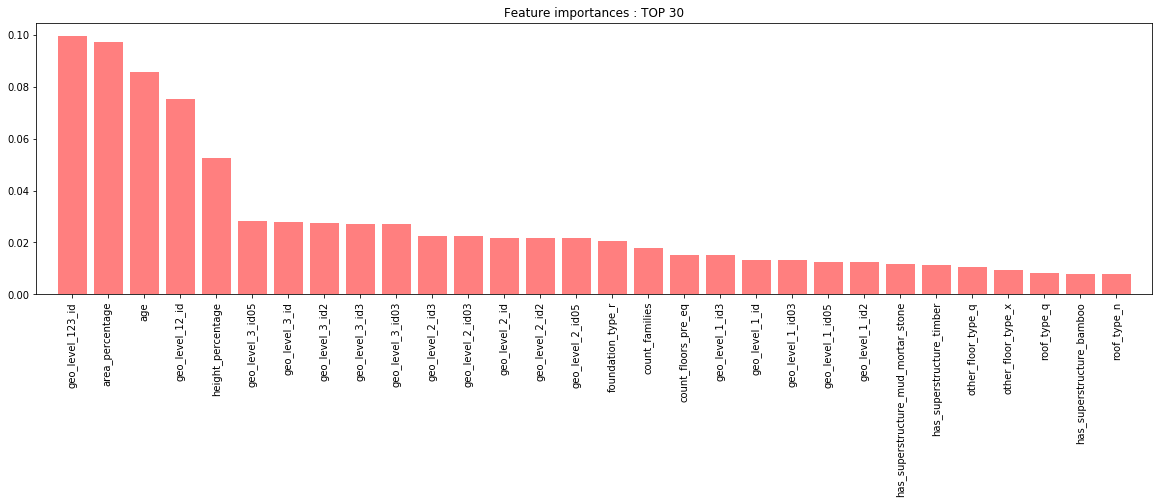

In [61]:
importances=np.mean([mean_tree(tree) for tree in gbrt_10_200.estimators_], axis=0)
top_feature_importance(X_train, importances, 30)

##### Modèle GradientBoostingClassifier max_depth = 15 n_estimators = 100 : gbrt_15_100             SUR APPRENTISSAGE

In [62]:
max_depth=15
n_estimators=200

with LoggerTimer("Durée d'exécution "):  
    gbrt_15_200 = GradientBoostingClassifier(random_state=94, max_depth=max_depth, n_estimators=n_estimators)
    gbrt_15_200.fit(X_train, y_train)
print("GradientBoostingClassifier max_depth={} n_estimators={} building_id suppr- Précision entraînement : {:.4f}"\
      .format(max_depth, n_estimators, gbrt_15_200.score(X_train, y_train)))
print("GradientBoostingClassifier max_depth={} n_estimators={} building_id suppr - Précision test : {:.4f}"\
      .format(max_depth, n_estimators,gbrt_15_200.score(X_test, y_test)))

 Durée d'exécution : 00h 48' 30" 
GradientBoostingClassifier max_depth=15 n_estimators=200 building_id suppr- Précision entraînement : 0.9846
GradientBoostingClassifier max_depth=15 n_estimators=200 building_id suppr - Précision test : 0.7293


##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Modèle LogisticRegression en cross validation

Il ne faut pas de données booléennes dans le dataframe, il faut donc préalablement les convertir en integer (à défaut python cesse de fonctionner)

In [66]:
X_train3=X_train.copy()
X_test3=X_test.copy()
data_columns_bool=['has_superstructure_adobe_mud','has_superstructure_mud_mortar_stone','has_superstructure_stone_flag',\
        'has_superstructure_cement_mortar_stone','has_superstructure_mud_mortar_brick',\
        'has_superstructure_timber','has_superstructure_bamboo',\
        'has_superstructure_cement_mortar_brick','has_superstructure_rc_non_engineered','has_superstructure_rc_engineered',\
        'has_superstructure_other','has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel',\
        'has_secondary_use_rental','has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry',\
        'has_secondary_use_health_post','has_secondary_use_gov_office','has_secondary_use_use_police','has_secondary_use_other']

X_train3[data_columns_bool]=X_train[data_columns_bool].astype(int)
X_test3[data_columns_bool]=X_test[data_columns_bool].astype(int)

In [76]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

with LoggerTimer("Durée d'exécution "):  
    clf=LogisticRegression(solver='saga', max_iter=1e5)
    clf.fit(X_train3, y_train)
print("LogisticRegression - Précision entraînement : {:.4f}"\
      .format(clf.score(X_train3, y_train)))
print("LogisticRegression - Précision test : {:.4f}"\
      .format(clf.score(X_test3, y_test)))

 Durée d'exécution : 00h 01' 11" 
LogisticRegression - Précision entraînement : 0.6101
LogisticRegression - Précision test : 0.6086


#### Modèle LogisticRegression avec GridSearch : grid

In [41]:
from sklearn.model_selection import GridSearchCV

with LoggerTimer("Durée d'exécution "):  
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
    grid = GridSearchCV(LogisticRegression(solver='saga', max_iter=1e5), param_grid, cv=5)
    grid.fit(X_train3, y_train)
print("LogisticRegression - Meilleur score de la cross-validation : {:.4f}".format(grid.best_score_))
print("LogisticRegression - Meilleurs parametres: ", grid.best_params_)
print("LogisticRegression C= {} - Score du test : {:.4f}".format(grid.best_params_, grid.score(X_test3, y_test)))

 Durée d'exécution : 00h 23' 22" 
LogisticRegression - Meilleur score de la cross-validation : 0.6098
LogisticRegression - Meilleurs parametres:  {'C': 1}
LogisticRegression C= {'C': 1} - Score du test : 0.6081


##### -------------------------------------------------------------------------------------------------------------------------------
#### Modèle XGBClassifier

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

with LoggerTimer("Durée d'exécution "):  
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
accuracy = accuracy_score(y_train, xgb.predict(X_train))
print("XGBClassifier - Précision sur entraînement : {:.4f}".format(accuracy))
accuracy = accuracy_score(y_test, xgb.predict(X_test))
print("XGBClassifier - Précision sur test : {:.4f}".format(accuracy))

 Durée d'exécution : 00h 02' 29" 
XGBClassifier - Précision sur entraînement : 0.6756
XGBClassifier - Précision sur test : 0.6756


In [78]:
max_depth=10

with LoggerTimer("Durée d'exécution "):  
    xgb_10 = XGBClassifier(max_depth=max_depth)
    xgb_10.fit(X_train, y_train)
accuracy = accuracy_score(y_train, xgb_10.predict(X_train))
print("XGBClassifier max_depth={} - Précision sur entraînement : {:.4f}".format(max_depth,accuracy))
accuracy = accuracy_score(y_test, xgb_10.predict(X_test))
print("XGBClassifier max_depth={} - Précision sur test : {:.4f}".format(max_depth,accuracy))

 Durée d'exécution : 00h 07' 01" 
XGBClassifier max_depth=10 - Précision sur entraînement : 0.7823
XGBClassifier max_depth=10 - Précision sur test : 0.7340


In [79]:
max_depth=6
n_estimators=150
learning_rate =0.1

xgb_6b = XGBClassifier(
     learning_rate =learning_rate,
     n_estimators=n_estimators,
     max_depth=max_depth,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     scale_pos_weight=1,
     seed=27)

with LoggerTimer("Durée d'exécution "):  
    xgb_6b.fit(X_train, y_train)
accuracy = accuracy_score(y_train, xgb_6b.predict(X_train))
print("XGBClassifier max_depth={} + - Précision sur entraînement : {:.4f}".format(max_depth, accuracy))
accuracy = accuracy_score(y_test, xgb_6b.predict(X_test))
print("XGBClassifier max_depth={} + - Précision sur test : {:.4f}".format(max_depth, accuracy))

 Durée d'exécution : 00h 05' 54" 
XGBClassifier max_depth=6 + - Précision sur entraînement : 0.7312
XGBClassifier max_depth=6 + - Précision sur test : 0.7207


In [80]:
max_depth=10
n_estimators=400

xgb_6 = XGBClassifier( 
     #learning_rate =0.5,
     n_estimators=n_estimators,
     max_depth=max_depth,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     scale_pos_weight=1,
     seed=94)

from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance

with LoggerTimer("Durée d'exécution "):  
    param_grid = {'learning_rate': [0.1, 0.2, 0.3]}
    grid = GridSearchCV(xgb_6, param_grid, cv=5)
    grid.fit(X_train, y_train)
print("XGBClassifier max_depth={} n_estimators={} - Meilleur score de la cross-validation : {:.4f}"\
      .format(max_depth, n_estimators, grid.best_score_))
print("XGBClassifier max_depth=10 + - Meilleurs parametres: ", grid.best_params_)

 Durée d'exécution : 05h 24' 01" 
XGBClassifier max_depth=10 n_estimators=400 - Meilleur score de la cross-validation : 0.7458
XGBClassifier max_depth=10 + - Meilleurs parametres:  {'learning_rate': 0.1}


In [15]:
max_depth=10
n_estimators=1000

xgb_6 = XGBClassifier( 
     n_estimators=n_estimators,
     max_depth=max_depth,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     scale_pos_weight=1,
     seed=94)

from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance

with LoggerTimer("Durée d'exécution "):  
    param_grid = {'learning_rate': [0.025, 0.05, 0.075, 0.1]}
    grid = GridSearchCV(xgb_6, param_grid, cv=5)
    grid.fit(X_train, y_train)
print("XGBClassifier max_depth={} n_estimators={} - Meilleur score de la cross-validation : {:.4f}"\
      .format(max_depth, n_estimators, grid.best_score_))
print("XGBClassifier max_depth=10 + - Meilleurs parametres: ", grid.best_params_)

 Durée d'exécution : 17h 59' 28" 
XGBClassifier max_depth=10 n_estimators=1000 - Meilleur score de la cross-validation : 0.7467
XGBClassifier max_depth=10 + - Meilleurs parametres:  {'learning_rate': 0.05}


In [16]:
accuracy = accuracy_score(y_test, grid.predict(X_test))
print("XGBClassifier max_depth={} n_estimators={} learning_rate = {} - Précision sur test : {:.4f}"\
          .format(max_depth, n_estimators, grid.best_params_['learning_rate'], accuracy))

XGBClassifier max_depth=10 n_estimators=1000 learning_rate = 0.05 - Précision sur test : 0.7505


##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Traitement du fichier de test à soumettre

In [22]:
def submission(file_in, file_out, model, columns_to_drop):
    test = pd.read_csv(file_in, sep=",", header=0)
    test_svg=test[columns_to_drop]
    test.drop(columns=[columns_to_drop], inplace=True)
    #print('Shape du fichier de tests : {}'.format(df_test_values.shape))

    test=polynome(test)
    test=categorized(test,data_columns_bool, data_columns_category)
    test=scalered(test, data_columns_integer)
    test=dummy(test)

    test_submission = pd.DataFrame(model.predict(test))
    test_submission.set_index(test_svg, inplace=True)
    test_submission.rename(columns={0: "damage_grade"}, inplace=True)

    test_submission.to_csv(file_out, sep=",")
    
    print('Shape du fichier soumis : {}'.format(test.shape))

In [25]:
file_test_values='data/test_values.csv'
file_test_results='data/test_values_submission.csv'
column_to_drop='building_id'

my_model=grid

with LoggerTimer("Durée d'exécution pour la soumission du modèle "):
    submission(file_test_values, file_test_results, my_model, column_to_drop)

Shape du fichier soumis : (86868, 82)
 Durée d'exécution pour la soumission du modèle : 00h 00' 28" 


In [112]:
importances=np.mean([mean_tree(tree) for tree in grid.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

top=X_train.shape[1]
top=30
indices=indices[:top]

plt.figure(1, figsize=(20, 5))
plt.title("Feature importances : TOP {}".format(top))
plt.bar(range(top), importances[indices], color="r", align="center", alpha=0.5)
plt.xticks(range(top), X_train.columns[indices], rotation='90')
plt.xlim([-1,top])
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'estimators_'

In [22]:
grid.cv_results_

{'mean_fit_time': array([3019.77834964, 2994.23378458, 2991.82776299, 3070.00527225]),
 'std_fit_time': array([ 4.49431948,  6.84879914,  2.49451367, 47.5873195 ]),
 'mean_score_time': array([28.94025254, 26.93931804, 28.1257997 , 29.89695086]),
 'std_score_time': array([0.35308049, 0.44726323, 0.18753252, 0.45870286]),
 'param_learning_rate': masked_array(data=[0.025, 0.05, 0.075, 0.1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.025},
  {'learning_rate': 0.05},
  {'learning_rate': 0.075},
  {'learning_rate': 0.1}],
 'split0_test_score': array([0.74832438, 0.74824763, 0.74586851, 0.74192888]),
 'split1_test_score': array([0.74287542, 0.74632898, 0.74182655, 0.73737529]),
 'split2_test_score': array([0.74939882, 0.74842671, 0.74548478, 0.74067536]),
 'split3_test_score': array([0.74638015, 0.74591967, 0.742901  , 0.73867997]),
 'split4_test_score': array([0.74433359, 0.74448708, 0.74111026, 0.73668